In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in all the words.
words = open('names.txt', 'r').read().splitlines()
print(f"Total amount of words: {len(words)}")

Total amount of words: 32033


In [3]:
# Build the vocabulary of characters and mappings to/from integers.
chars = sorted(list(set(''.join(words))))
stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}
vocabulary_size = len(itos)
print(f"Vocabulary size: {vocabulary_size}")

Vocabulary size: 27


In [4]:
def build_dataset(words: list[str], context_size: int = 3, logging: bool = False) -> tuple[torch.tensor]:
    """
    Given an list of string words, creates input and output targets.
    Args:
        words(list[int], shape=[n]): List of all words to sample examples from.
        context_size(int)          : How many characters are considered for prediction.
        logging(bool)              : Whether to print builded examples or not.
    Returns:
        X(torch.tensor, shape=[m, contex size]): Input tensor, where m is number of examples.
        Y(torch.tensor, shape=[m])             : Target tensor, where m is number of examples.
    """
    X, Y = [], []
    for word in words:
        context = [0] * context_size
        for ch in word + '.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    if logging:
        print(f'Input: {X.shape}, Output: {Y.shape}')
    return X, Y

In [5]:
from typing import Any


class Linear():
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias      
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

class BatchNorm1d():
    def __init__(self, dim: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained wdith a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.tensor) -> torch.tensor:
        if self.training:
            # check input's dimensionality
            if x.dim() == 2:
                dim = 0
            elif x.dim() == 3:
                dim = (0, 1)
            else:
                raise Exception(f'Able to process 2D or 3D tensors only, received {x.dim()}D tensor')
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1.0 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1.0 - self.momentum) + xvar * self.momentum
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh():
    def __call__(self, x: torch.tensor) -> torch.tensor:
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding():
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX: torch.tensor) -> torch.tensor:
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self) -> list[torch.tensor]:
        return [self.weight]
    

class FlattenConsecutive():
    def __init__(self, n: int) -> None:
        self.n = n  # number of consecutice elements

    def __call__(self, x: torch.tensor) -> torch.tensor:
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return []
    

class Sequential():
    def __init__(self, layers: list) -> None:
        self.layers = layers
    
    def __call__(self, x: Any) -> Any:
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self) -> list:
        return [p for layer in self.layers for p in layer.parameters()]

In [6]:
torch.manual_seed(13);

In [7]:
# Split the dataset on train, development and test set.
import random
random.seed(13)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)


block_size = 8  # how many charecters do we take to predict the next one?
Xtrain, Ytrain = build_dataset(words[:n1], block_size, True)     # 80%
Xdevelop, Ydevelop = build_dataset(words[n1:n2], block_size, True) # 10%
Xtest, Ytest = build_dataset(words[n2:], block_size, True)     # 10%

Input: torch.Size([182597, 8]), Output: torch.Size([182597])
Input: torch.Size([22761, 8]), Output: torch.Size([22761])
Input: torch.Size([22788, 8]), Output: torch.Size([22788])


In [8]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split: str, evaluated_model: Sequential) -> None:
    """
    Given a split name, evaluates it and prints the result.
    Args:
        split(str): name of the dataset split you'd like to evaluate.
    """
    x, y = {  # Sets are global!
        'train': (Xtrain, Ytrain),
        'dev': (Xdevelop, Ydevelop),
        'test': (Xtest, Ytest)
    }[split]
    
    # swith to evaluation mode
    for layer in evaluated_model.layers:
        layer.training = False

    logits =  evaluated_model(x)
    loss = F.cross_entropy(logits, y)

    # switch back to training mode
    for layer in evaluated_model.layers:
        layer.training = True
    
    return loss.item()

In [49]:
def train_model(
        n_embd: int, n_hidden: int, vocab_size: int,  # model's paramerers
        max_steps: int, batch_size: int, lr: float,   # training settings
        Xtr: torch.tensor, Ytr: torch.tensor          # training and target sets
) -> list:
    """
    Inintializes the models using given parameters and trains it with given settings on given sets.
    """

    model = Sequential([
        Embedding(vocab_size, n_embd), 
        FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, vocab_size)
    ])

    with torch.no_grad():
        model.layers[-1].weight *= 0.01  # make last layer less confident
    parameters = model.parameters()
    print(sum(p.nelement() for p in parameters))
    for p in parameters:
        p.requires_grad = True
    
    lossi = []
    trains = []
    develops = []
    for i in range(max_steps):
        """Mini-batch construct"""
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y
        
        """Forward pass"""
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)  # loss function
        
        """Backward pass"""
        for p in parameters:
            p.grad = None
        loss.backward()
        
        """Update"""
        # lr = 1.0 if i < 90000 else 0.01  # learning step decay
        if i % 20000 == 0:
            lr *= 0.97
        if i > 150000:
            lr = 0.01
            batch_size = 64
        for p in parameters:
            p.data += -lr * p.grad
        
        """Track stats"""
        if i % 10000 == 0:
            print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
            train_loss = split_loss('train', model)
            develop_loss = split_loss('dev', model)
            trains.append(train_loss)
            develops.append(develop_loss)
        lossi.append(loss.log10().item())

    """Plotting"""
    # plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
    # train_loss = split_loss('train', model)
    # devlop_loss = split_loss('dev', model)
    return [trains, develops, lossi]

In [50]:
embedding_dim = 40
hidden_neurons = 120
learning_rate = 0.257#0.5#0.7327
iterations = 200000
minibatch_size = 32

In [12]:
# learning rate = 0.7327, 0.25
trains, develops = [], []
lrs = torch.linspace(1.0, 0.01, 5).tolist()
for i in range(len(lrs)):
    learning_rate = lrs[i]
    trains, develops, losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(trains[-1])
    develops.append(develops[-1])

    print('-'*40)
    print(f'{learning_rate = }')
    print(' Train | Develop')
    print(trains[-1], develops[-1])
    print('-'*40)

plt.plot(lrs, trains)
plt.plot(lrs, develops)

50137
      0/ 200000: 3.2962


KeyboardInterrupt: 

In [34]:
torch.set_num_threads(32)

In [ ]:
# Bigger size is better, 256 seemed best on 8 context length
trains, develops = [], []
batch_sizes = [256, 512]
for i in range(len(batch_sizes)):
    minibatch_size = batch_sizes[i]
    losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(losses[0])
    develops.append(losses[1])

    print('-'*40)
    print(f'{minibatch_size = }')
    print(' Train | Develop')
    print(losses)
    print('-'*40)

plt.plot(batch_sizes, trains)
plt.plot(batch_sizes, develops)

In [119]:
# 20 is good
trains, develops = [], []
embdims = [4, 8, 12, 16, 20, 24, 28]
for i in range(len(embdims)):
    embedding_dim = embdims[i]
    trs, devs, losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(trs[-1])
    develops.append(devs[-1])

    print('-'*40)
    print(f'{embedding_dim = }')
    print(' Train | Develop')
    print(trs[-1], devs[-1])
    print('-'*40)

plt.plot(embdims, [tr.item() for tr in trains])
plt.plot(embdims, [dev.item() for dev in develops])

22605
      0/  10000: 3.2955
   1000/  10000: 2.4760
   2000/  10000: 2.3594
   3000/  10000: 2.1840
   4000/  10000: 2.2305
   5000/  10000: 2.5931
   6000/  10000: 2.0510
   7000/  10000: 2.3236
   8000/  10000: 1.8810
   9000/  10000: 2.1109
----------------------------------------
embedding_dim = 4
 Train | Develop
2.15006160736084 2.1831321716308594
----------------------------------------
23273
      0/  10000: 3.2955
   1000/  10000: 2.1431
   2000/  10000: 2.3586
   3000/  10000: 2.1735
   4000/  10000: 2.0052
   5000/  10000: 2.3233
   6000/  10000: 2.3741
   7000/  10000: 2.0575
   8000/  10000: 2.1175
   9000/  10000: 2.0643
----------------------------------------
embedding_dim = 8
 Train | Develop
2.115809202194214 2.16291880607605
----------------------------------------
23941
      0/  10000: 3.2950
   1000/  10000: 2.3502
   2000/  10000: 2.2028
   3000/  10000: 2.3089
   4000/  10000: 2.2177
   5000/  10000: 2.2565
   6000/  10000: 2.1711
   7000/  10000: 2.3632
   80

AttributeError: 'float' object has no attribute 'item'

9887
      0/  10000: 3.2957
   1000/  10000: 2.3895
   2000/  10000: 2.1604
   3000/  10000: 2.3616
   4000/  10000: 1.9456
   5000/  10000: 2.0524
   6000/  10000: 2.2385
   7000/  10000: 2.1490
   8000/  10000: 2.1307
   9000/  10000: 2.1992
----------------------------------------
hidden_neurons = 40
 Train | Develop
2.127599000930786 2.15541410446167
----------------------------------------
14217
      0/  10000: 3.2957
   1000/  10000: 2.2374
   2000/  10000: 2.2025
   3000/  10000: 2.4768
   4000/  10000: 2.1942
   5000/  10000: 2.0518
   6000/  10000: 2.0729
   7000/  10000: 2.1808
   8000/  10000: 1.8511
   9000/  10000: 2.3014
----------------------------------------
hidden_neurons = 50
 Train | Develop
2.1007065773010254 2.1337342262268066
----------------------------------------
19347
      0/  10000: 3.2955
   1000/  10000: 2.3586
   2000/  10000: 2.3541
   3000/  10000: 2.1339
   4000/  10000: 2.3487
   5000/  10000: 2.1437
   6000/  10000: 2.0633
   7000/  10000: 2.0565


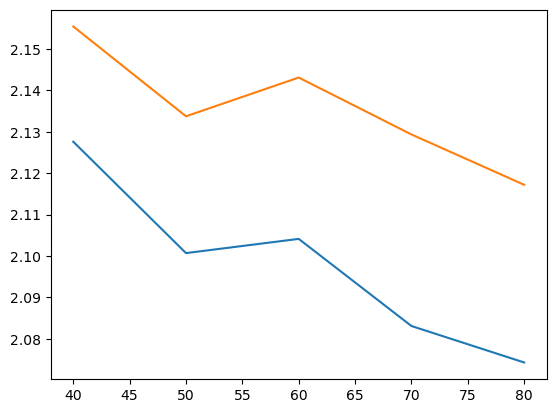

In [123]:
# 70 is good
trains, develops = [], []
neurons_amounts = [40, 50, 60, 70, 80]
for i in range(len(neurons_amounts)):
    hidden_neurons = neurons_amounts[i]
    trs, devs, losses = train_model(
        embedding_dim,
        hidden_neurons,
        vocabulary_size,
        iterations,
        minibatch_size,
        learning_rate,
        Xtrain, Ytrain
    )
    trains.append(trs[-1])
    develops.append(devs[-1])

    print('-'*40)
    print(f'{hidden_neurons = }')
    print(' Train | Develop')
    print(trs[-1], devs[-1])
    print('-'*40)

plt.plot(neurons_amounts, trains)
plt.plot(neurons_amounts, develops)

In [51]:
trains, develops, losses= train_model(
    embedding_dim,
    hidden_neurons,
    vocabulary_size,
    iterations,
    minibatch_size,
    learning_rate,
    Xtrain, Ytrain
)

losses = torch.tensor(losses).view(-1, 1000).sum(1).tolist()

72267
      0/ 200000: 3.2937
  10000/ 200000: 1.9888
  20000/ 200000: 2.2617
  30000/ 200000: 1.8993
  40000/ 200000: 2.1750
  50000/ 200000: 2.0102
  60000/ 200000: 2.1025
  70000/ 200000: 1.7214
  80000/ 200000: 1.6774
  90000/ 200000: 1.7541
 100000/ 200000: 1.9380
 110000/ 200000: 1.4028
 120000/ 200000: 1.4980
 130000/ 200000: 2.0226
 140000/ 200000: 2.0066
 150000/ 200000: 1.6397
 160000/ 200000: 2.0559
 170000/ 200000: 1.7135
 180000/ 200000: 1.8001
 190000/ 200000: 1.2147


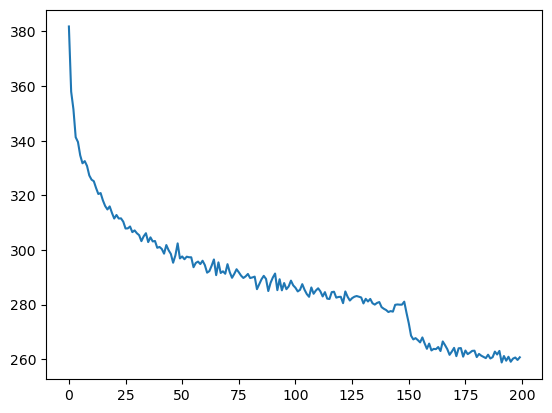

In [52]:
plt.plot(losses);

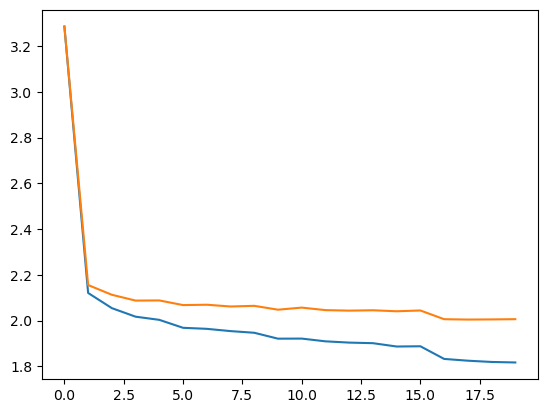

In [53]:
plt.plot(trains)
plt.plot(develops);

In [ ]:
""" Sampling from model
# Sample from the model.
g = torch.Generator().manual_seed(13 + 10)
for _ in range (20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context])) # (1, block_size, n_embd)
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '' token, break
        if ix == 0:
            break
    print("".join(itos[i] for i in out)) # decode and print the generated word
"""

In [55]:
trains[-1], develops[-1]

(1.8165212869644165, 2.0059585571289062)

In [56]:
develops

[3.286442279815674,
 2.155273675918579,
 2.1126976013183594,
 2.0872652530670166,
 2.087939500808716,
 2.0675771236419678,
 2.06917142868042,
 2.0614511966705322,
 2.0643179416656494,
 2.0474259853363037,
 2.0565781593322754,
 2.0455830097198486,
 2.0433194637298584,
 2.044924259185791,
 2.0405561923980713,
 2.0440115928649902,
 2.0058629512786865,
 2.0042388439178467,
 2.004897117614746,
 2.0059585571289062]

In [215]:
develops

[3.2656590938568115,
 2.159106731414795,
 2.125878095626831,
 2.0876688957214355,
 2.092001438140869,
 2.072784662246704,
 2.078343629837036,
 2.0610110759735107,
 2.0575573444366455,
 2.0469956398010254]

In [224]:
develops

[3.2691969871520996,
 2.1587774753570557,
 2.1249985694885254,
 2.0941884517669678,
 2.0815343856811523,
 2.0787274837493896,
 2.0683348178863525,
 2.0674710273742676,
 2.077599048614502,
 2.067131519317627]

In [244]:
develops

[3.203528881072998,
 2.186952590942383,
 2.183722496032715,
 2.138371229171753,
 2.124286413192749,
 2.1255569458007812,
 2.103883743286133,
 2.0913546085357666,
 2.10239839553833,
 2.0895018577575684,
 2.1002871990203857,
 2.1136233806610107,
 2.118013620376587,
 2.105360746383667,
 2.0979137420654297,
 2.09718656539917,
 2.0246896743774414,
 2.019160270690918,
 2.016582727432251,
 2.013521432876587]

In [18]:
develops

[3.21083664894104,
 2.1911911964416504,
 2.1839706897735596,
 2.167095899581909,
 2.1189751625061035,
 2.1447341442108154,
 2.122999668121338,
 2.1254045963287354,
 2.146267890930176,
 2.0906078815460205,
 2.0355048179626465,
 2.0313072204589844,
 2.02898907661438,
 2.029597520828247,
 2.027207851409912,
 2.0242228507995605,
 2.0249338150024414,
 2.023837089538574,
 2.0245559215545654,
 2.0242929458618164]

In [26]:
develops

[3.2608072757720947,
 2.1477713584899902,
 2.118455648422241,
 2.105483293533325,
 2.089350461959839,
 2.08015775680542,
 2.071908712387085,
 2.059954881668091,
 2.0626676082611084,
 2.058481454849243,
 2.0705559253692627,
 2.014397144317627,
 2.0116045475006104,
 2.0121335983276367,
 2.0098140239715576,
 2.0099775791168213,
 2.0102055072784424,
 2.0091326236724854,
 2.0095627307891846,
 2.00886607170105]

In [36]:
develops

[3.278215169906616,
 2.1494829654693604,
 2.1075503826141357,
 2.08491587638855,
 2.081678628921509,
 2.071765661239624,
 2.063577175140381,
 2.0609893798828125,
 2.052854537963867,
 2.061706781387329,
 2.0476648807525635,
 2.0020108222961426,
 1.999455451965332,
 1.9996072053909302,
 2.000478982925415,
 2.0001282691955566,
 2.001126766204834,
 1.9994657039642334,
 1.9999414682388306,
 2.0013375282287598]